In [1]:
import cv2
from glob import glob
from matplotlib import pyplot as plt
from numpy import floor
import random
import numpy as np
import os
import itertools

import keras
from keras.layers import Conv2D, Dense, Dropout, Flatten
from keras.models import Sequential
from keras.callbacks import EarlyStopping, History
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf

/Users/ray/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Visualizing the data and their labels

# first set random state for consistency
np.random.seed(99)

# define a function to show an image with its label using its path in the folder
def plot_samp(letter):
    impath = './asl_alphabet_train/' + letter + '/**'
    plt.imshow(cv2.imread(glob(impath)[np.random.randint(low = 0, high = 2999)]))
    plt.title(letter)

In [3]:
# getting labels of data from folder directory as a list

# setting the directory
train_dir = './asl_alphabet_train/'
test_dir = './asl_alphabet_test/'

# list of directory
train_folders = os.listdir(train_dir)
test_files = os.listdir(test_dir)

# taking out "ds.store"
tr_fold = train_folders[1:30]
tr_fold

['R',
 'U',
 'I',
 'N',
 'G',
 'Z',
 'T',
 'S',
 'A',
 'F',
 'O',
 'H',
 'del',
 'nothing',
 'space',
 'M',
 'J',
 'C',
 'D',
 'V',
 'Q',
 'X',
 'E',
 'B',
 'K',
 'L',
 'Y',
 'P',
 'W']

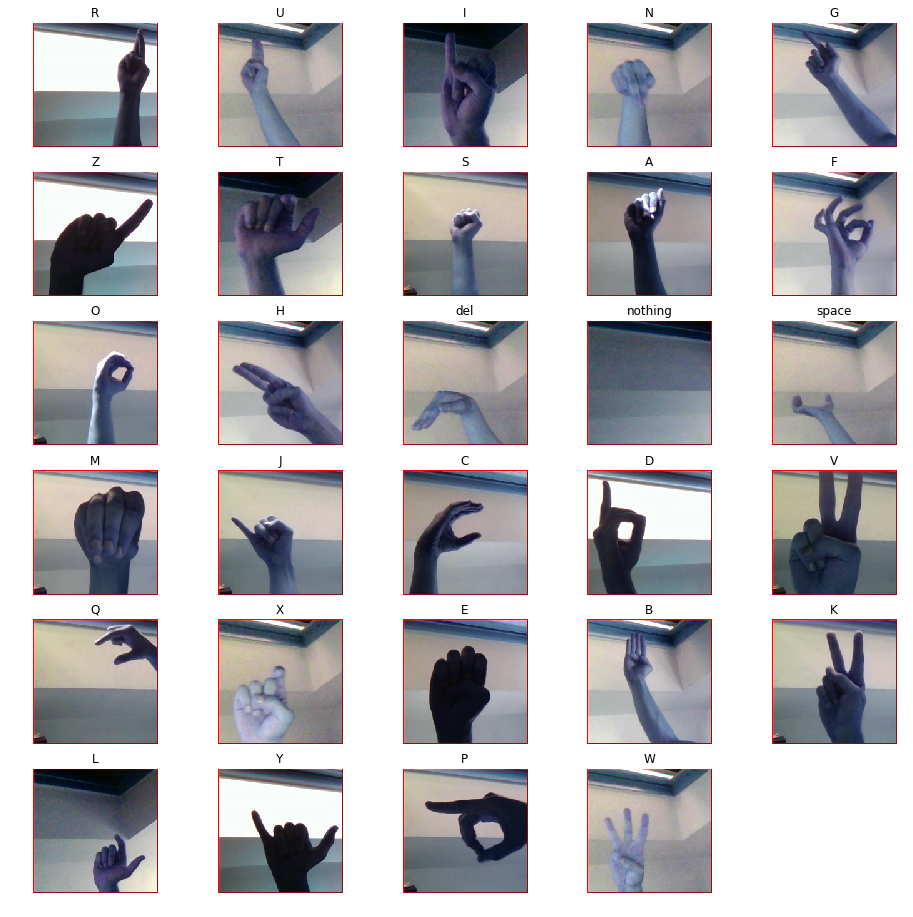

In [4]:
# setting size of each plotted image
plt.figure(figsize = (16,16))

# showing an image for every class
for i in range(len(tr_fold)):
    plt.subplot(6, 5, i + 1).axis('off') # showing the classes in 6 rows and 5 columns
    plot_samp(tr_fold[i]) # use previously created function

In [5]:
# get images in an array

x_train, y_train = [], []
for folder in tr_fold:  #for each folder in the training directory,
    files = os.listdir(train_dir + folder)  #get files from that folder name in the training directory
    print('Reading images from ' + train_dir + folder + '/ ...') #update user on which folder the code is working on
    for file in files[:1500]:  #for each file within a specific folder name
        img = cv2.imread(train_dir + folder + '/' + file) #get the images 
        img = cv2.resize(img, (64, 64)) #resize the images to 64 by 64
        x_train.append(img)  #append resized image to x_train list
        y_train.append(folder) #append label of image to y_train list
        
# normalize data
xtrain = np.divide(x_train, 255)

# change the lists into arrays        
xtrain = np.asarray(xtrain) 
y_train = np.asarray(y_train)

Reading images from ./asl_alphabet_train/R/ ...
Reading images from ./asl_alphabet_train/U/ ...
Reading images from ./asl_alphabet_train/I/ ...
Reading images from ./asl_alphabet_train/N/ ...
Reading images from ./asl_alphabet_train/G/ ...
Reading images from ./asl_alphabet_train/Z/ ...
Reading images from ./asl_alphabet_train/T/ ...
Reading images from ./asl_alphabet_train/S/ ...
Reading images from ./asl_alphabet_train/A/ ...
Reading images from ./asl_alphabet_train/F/ ...
Reading images from ./asl_alphabet_train/O/ ...
Reading images from ./asl_alphabet_train/H/ ...
Reading images from ./asl_alphabet_train/del/ ...
Reading images from ./asl_alphabet_train/nothing/ ...
Reading images from ./asl_alphabet_train/space/ ...
Reading images from ./asl_alphabet_train/M/ ...
Reading images from ./asl_alphabet_train/J/ ...
Reading images from ./asl_alphabet_train/C/ ...
Reading images from ./asl_alphabet_train/D/ ...
Reading images from ./asl_alphabet_train/V/ ...
Reading images from ./asl_al

In [6]:
dims = xtrain[0].shape
print(xtrain.shape, y_train.shape, dims)

(43500, 64, 64, 3) (43500,) (64, 64, 3)


In [7]:
#use same steps to get the final testing data set

xgivtest, ygivtest = [], []
for file in test_files:
    img = cv2.imread(test_dir + file)
    img = cv2.resize(img, (64, 64))
    xgivtest.append(img)
    ygivtest.append(file.split('_')[0])
    
xgivtest = np.divide(xgivtest, 255)    

xgivtest = np.asarray(xgivtest) 
ygivtest = np.asarray(ygivtest)

In [8]:
print(xgivtest.shape, ygivtest.shape)

(28, 64, 64, 3) (28,)


In [9]:
classes = np.unique(y_train)           # list of classes in alphabetical order
label = np.array(range(29))            # numbered label for every class
lab_dict = dict(zip(classes, label))   # dictionary connecting every class to its label

In [10]:
# creating ytrain as list of its numbered label

ytrain = []
for lab in y_train:
    ytrain.append(lab_dict[lab])

In [11]:
# creating y_givtest as list of its numbered label

ygivnumtest = []
for lab in ygivtest:
    ygivnumtest.append(lab_dict[lab])

In [12]:
# encoding the y labels

ytrain_enc = to_categorical(ytrain, num_classes = 29)
ygivtest_enc = to_categorical(ygivnumtest, num_classes = 29)

print(ytrain_enc.shape, ygivtest_enc.shape)

(43500, 29) (28, 29)


In [13]:
# function to flip images horizontally
# this data augmentation technique is used because the ASL alphabet looks different when signed by someone who
# is right-handed vs someone who is left-handed

def flip_images(X_imgs):
    #create empty list
    X_flip = []
    
    #reset the global tensorflow graph
    tf.reset_default_graph()
    
    #set a placeholder variable
    X = tf.placeholder(tf.float32, shape = dims)
    
    # use tensorflow.image's flip_left_right function with placeholder
    tf_img1 = tf.image.flip_left_right(X)
    
    # run the tensorflow session to flip the images horizontally
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for img in X_imgs:
            flipped_imgs = sess.run([tf_img1], feed_dict = {X: img})
            X_flip.extend(flipped_imgs)
    X_flip = np.array(X_flip, dtype = np.float32)
    return X_flip

# run the function to produce the new augmented images
flipped_images = flip_images(xtrain)

In [14]:
# similar steps as above to randomly adjust the lighting for each image

def adjust_color_images(X_imgs):
    X_color_adjust = []
    
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = dims)
    
    tf_img = tf.image.random_hue(X, max_delta=0.05)
    tf_img = tf.image.random_contrast(tf_img, lower=0.3, upper=1.0)
    tf_img = tf.image.random_brightness(tf_img, max_delta=0.2)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for img in X_imgs:
            flipped_imgs = sess.run([tf_img], feed_dict = {X: img})
            X_color_adjust.extend(flipped_imgs)
    X_color_adjust = np.array(X_color_adjust, dtype = np.float32)
    return X_color_adjust

color_adjusted = adjust_color_images(xtrain)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5,1,'Color Adjusted Image')

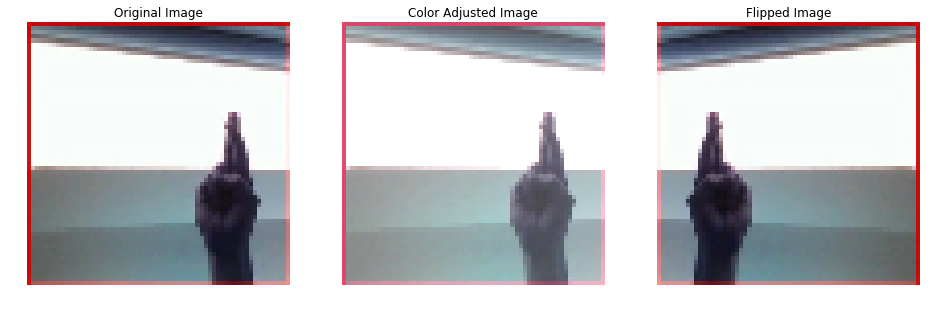

In [15]:
#plotting results of data augmentaiton

plt.figure(figsize = (16,16))

plt.subplot(1, 3, 1).axis('off')
plt.imshow(xtrain[0])
plt.title('Original Image')

plt.subplot(1, 3, 3).axis('off')
plt.imshow(flipped_images[0])
plt.title('Flipped Image')

plt.subplot(1, 3, 2).axis('off')
plt.imshow(color_adjusted[0])
plt.title('Color Adjusted Image')

In [16]:
print(xtrain.shape, flipped_images.shape, color_adjusted.shape)

(43500, 64, 64, 3) (43500, 64, 64, 3) (43500, 64, 64, 3)


In [17]:
# put all images in one list
allxtrain = np.concatenate((xtrain, flipped_images, color_adjusted), axis = 0)

# concatenate labels of training set
allytrain = np.concatenate((ytrain_enc, ytrain_enc, ytrain_enc), axis = 0)

In [18]:
print(allxtrain.shape, allytrain.shape)

(130500, 64, 64, 3) (130500, 29)


In [19]:
# shuffle the data to reduce bias in training data
#xtrainshuf, ytrainshuf = shuffle(allxtrain, allytrain, random_state=0)

In [20]:
%%time

# split this data into training and testing

Xtrain, Xtest, yTrain, yTest = train_test_split(allxtrain, allytrain, shuffle = True, test_size = .3)

CPU times: user 8.11 s, sys: 1min 24s, total: 1min 32s
Wall time: 5min 45s


In [21]:
# concatenate the testing set with the given test set

xtest = np.concatenate((Xtest, xgivtest), axis = 0)
ytest = np.concatenate((yTest, ygivtest_enc), axis = 0)

In [22]:
print(Xtrain.shape, xtest.shape, yTrain.shape, ytest.shape)

(91350, 64, 64, 3) (39178, 64, 64, 3) (91350, 29) (39178, 29)


In [23]:
mod = Sequential()
mod.add(Conv2D(64, kernel_size = 3, activation = 'relu', input_shape = dims))
mod.add(Flatten())
mod.add(Dense(100, activation = 'relu'))
mod.add(Dropout(.4))
mod.add(Dense(100, activation = 'relu'))
mod.add(Dense(29, activation = 'softmax'))
mod.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [24]:
early_stop = EarlyStopping(patience = 3)
mod_h = mod.fit(Xtrain, yTrain, epochs = 35, validation_split = .3, callbacks = [early_stop])

Train on 63944 samples, validate on 27406 samples
Epoch 1/35
63944/63944 [==============================] - 1049s 16ms/step - loss: 2.0467 - acc: 0.3619 - val_loss: 0.8641 - val_acc: 0.7204
Epoch 2/35
63944/63944 [==============================] - 804s 13ms/step - loss: 1.0131 - acc: 0.6345 - val_loss: 0.5634 - val_acc: 0.8126
Epoch 3/35
63944/63944 [==============================] - 772s 12ms/step - loss: 0.7824 - acc: 0.7151 - val_loss: 0.4233 - val_acc: 0.8583
Epoch 4/35
63944/63944 [==============================] - 769s 12ms/step - loss: 0.6549 - acc: 0.7636 - val_loss: 0.3690 - val_acc: 0.8803
Epoch 5/35
63944/63944 [==============================] - 767s 12ms/step - loss: 0.5847 - acc: 0.7911 - val_loss: 0.3133 - val_acc: 0.8997
Epoch 6/35
63944/63944 [==============================] - 768s 12ms/step - loss: 0.5292 - acc: 0.8113 - val_loss: 0.3172 - val_acc: 0.8920
Epoch 7/35
63944/63944 [==============================] - 769s 12ms/step - loss: 0.4836 - acc: 0.8312 - val_loss: 0

In [25]:
# evaluating model on the testing data

score = mod.evaluate(xtest, ytest, verbose=0)
print("Final loss:", score[0], "  Final accuracy:", score[1])

Final loss: 0.26141515422254524   Final accuracy: 0.9190617183112971


With a testing accuracy of 92%, the model seems to be proficient at classifying the ASL signs.  One thing to note is that all of the pictures have a similar background of being indoors and in front of a wall.  This model will probably not do as well if new pictures were taken with a different background, such as outdoors background.

In [26]:
# create a list of unencoded labels for the training set

yTrain_unenc = []

for i in range(len(yTrain)):
    yTrain_unenc.append(np.argmax(yTrain[i]))

In [27]:
# using confusion matrix to see what as predicted as what

# get predicted probability distribution of classes using model for xTrain

mod_pred_y_all = mod.predict(Xtrain, verbose = 1)      

# get class with highest probability
mod_pred_y = np.argmax(mod_pred_y_all, axis = 1)

# get confusion matrix with the actual labels and the predicted labels
conmat = confusion_matrix(yTrain_unenc, mod_pred_y)

91350/91350 [==============================] - 212s 2ms/step


In [28]:
# plotting confusion matrix.  function taken straight from scikit-learn website to make confusion matrix look nice

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


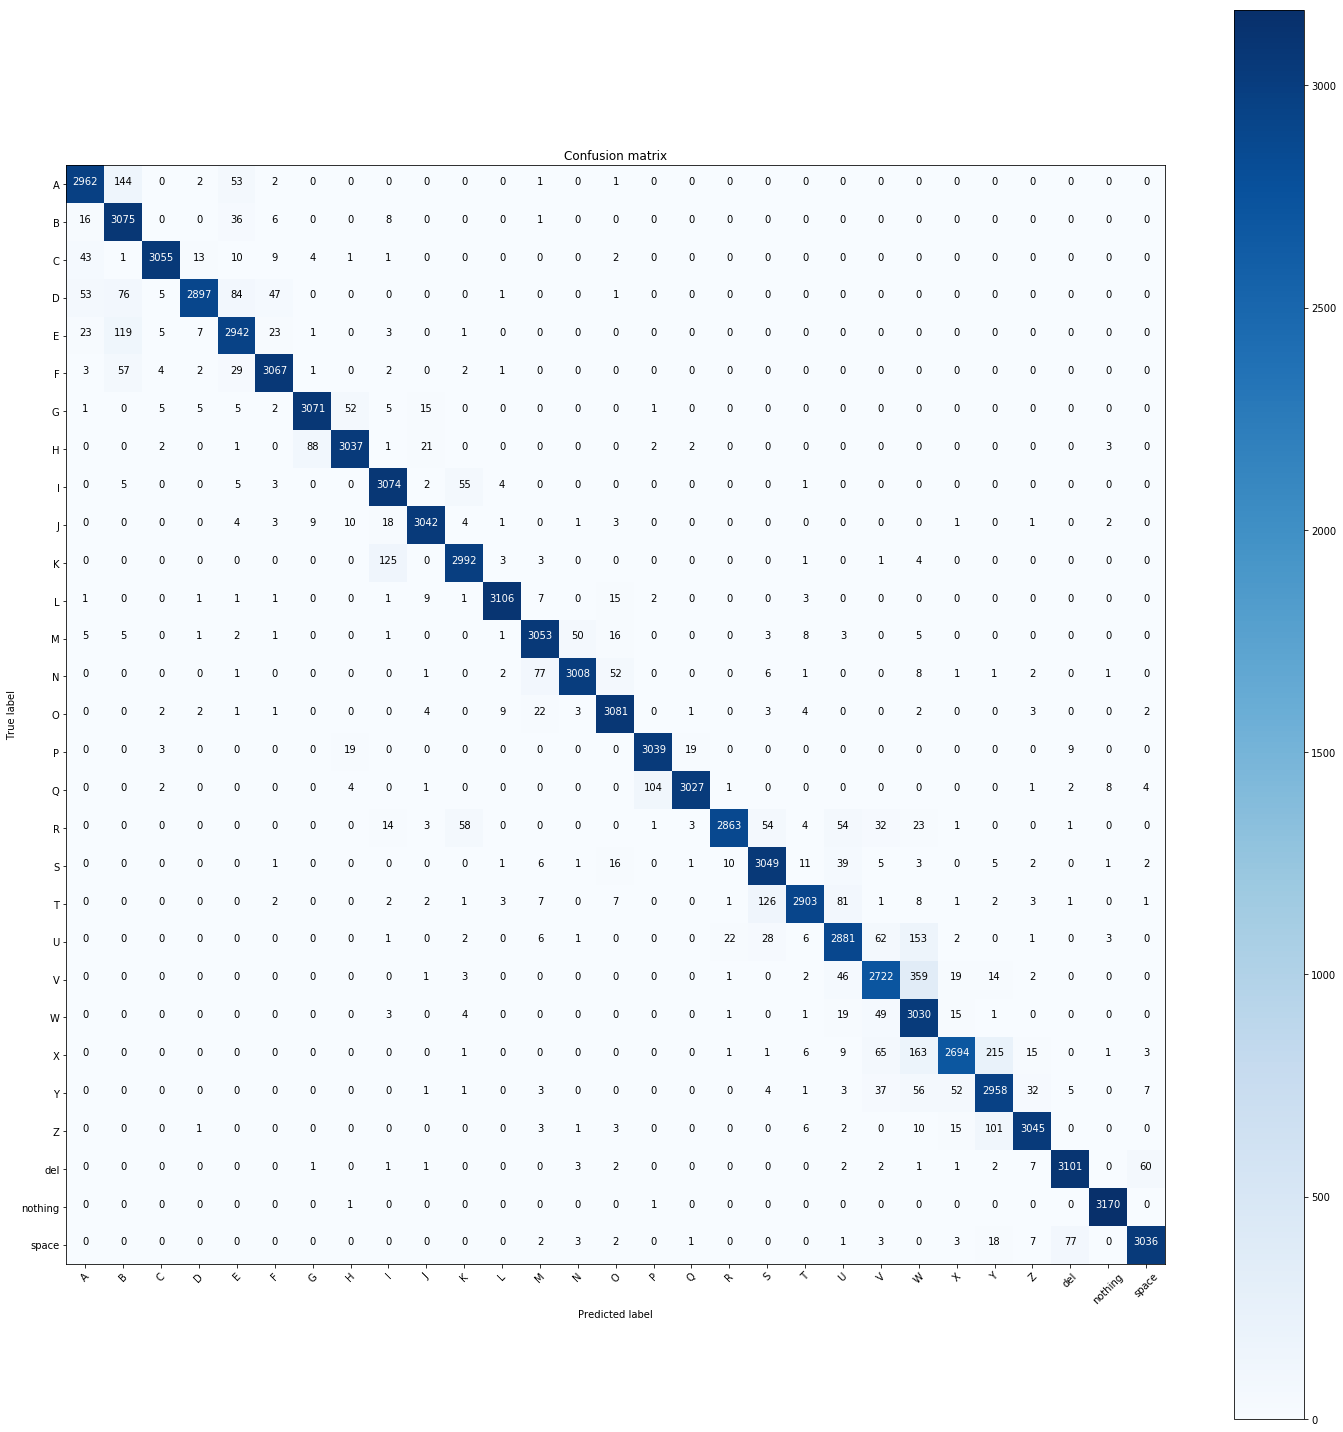

In [29]:
plt.figure(figsize = (20,20))
plot_confusion_matrix(conmat, classes)

Of note that images classified as 'nothing' have the highest percentage of being correctly labelled.  This makes sense as the 'nothing' label is the most distinct as it is the only class that doesn't have a hand in the picture.

Also of note is that the 'V' label is also commonly misclassified as the 'W' label.  These two signs are also very similar, so this common misclassification is not a surprise.

Finally, the 'X' label seems to be the most misclassified.

In [30]:
print(mod_h.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


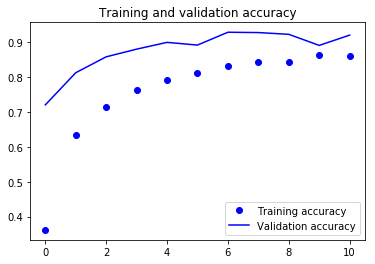

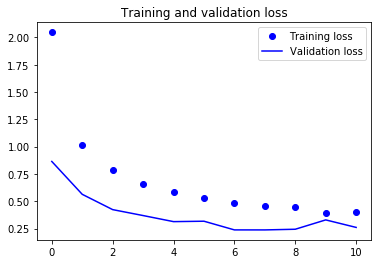

In [31]:
# using keras' History to get back accuracy and loss for training and validation set for each epoch

accuracy = mod_h.history['acc']
val_accuracy = mod_h.history['val_acc']
loss = mod_h.history['loss']
val_loss = mod_h.history['val_loss']

# epochs as length of 
epochs = range(len(accuracy))

# plotting accuracy for training and validation
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

# plotting loss for training and validation
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Curiously enough, it seems that the validation accuracy is consistently higher than the training accuracy.  

In [32]:
# looking at some missclassified pictures

# Create new arrays of which images are in/correctly classified
correct = np.nonzero(mod_pred_y == yTrain_unenc)[0]
incorrect = np.nonzero(mod_pred_y != yTrain_unenc)[0]

In [33]:
correct.shape

(86980,)

In [34]:
incorrect.shape

(4370,)

In [35]:
# confirming the shapes add up to 91350
88712 + 2638

91350

In [36]:
# import to randomize indices for later
from random import randint

In [37]:
# create list of the predicted images as their class (rather than numbered label)

class_dict = dict(zip(label, classes))

modpredclass = []
for classes0 in mod_pred_y:
    modpredclass.append(class_dict[classes0])

In [38]:
# create list of training images as their class (rather than numbered label)

trainclass = []
for classes1 in yTrain_unenc:
    trainclass.append(class_dict[classes1])

<Figure size 432x288 with 0 Axes>

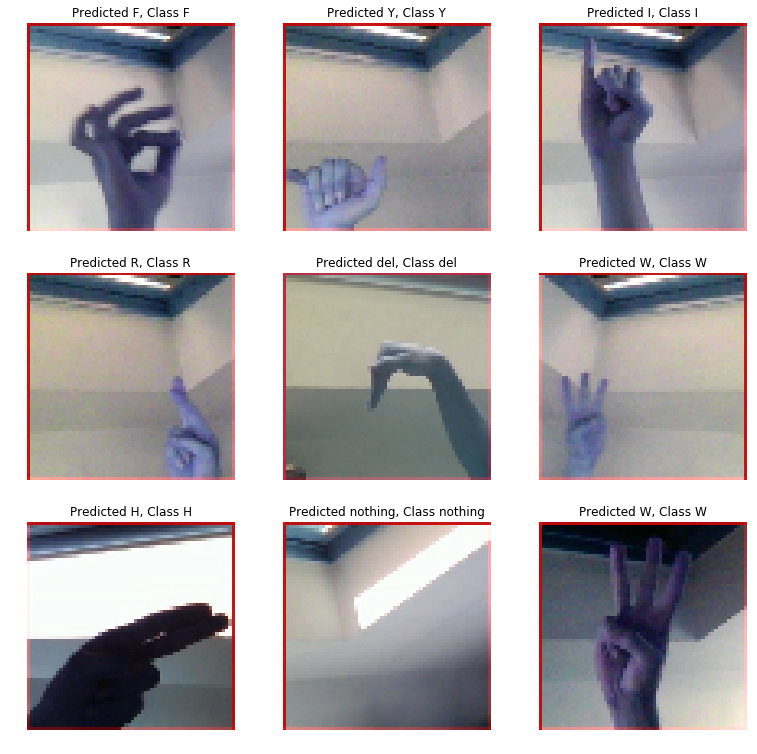

In [39]:
# plotting both correctly and incorrectly labeled images

plt.figure()
plt.figure(figsize = (13,13)) #tweaking size of each image

# getting 9 random correctly classified images
for i, corr in enumerate(correct[[randint(0, len(correct)-1), randint(0, len(correct)-1), randint(0, len(correct)-1)
        , randint(0, len(correct)-1), randint(0, len(correct)-1), randint(0, len(correct)-1)
        , randint(0, len(correct)-1), randint(0, len(correct)-1), randint(0, len(correct)-1)]]):
    plt.subplot(3,3,i+1).axis('off')
    plt.imshow(Xtrain[corr].reshape(64,64,3), cmap='gray', interpolation='none')  # plot the image
    plt.title("Predicted {}, Class {}".format(modpredclass[corr], trainclass[corr])) # show image's predicted and actual class


<Figure size 432x288 with 0 Axes>

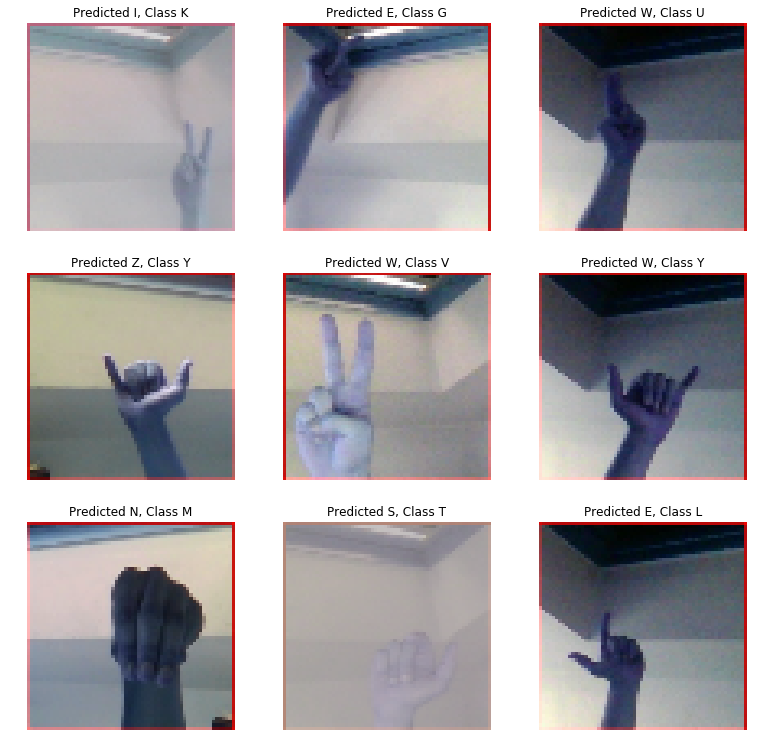

In [40]:
plt.figure()
plt.figure(figsize = (13,13))
for i, incorr in enumerate(incorrect[[randint(0, len(incorrect)-1), randint(0, len(incorrect)-1), randint(0, len(incorrect)-1)
        , randint(0, len(incorrect)-1), randint(0, len(incorrect)-1), randint(0, len(incorrect)-1)
        , randint(0, len(incorrect)-1), randint(0, len(incorrect)-1), randint(0, len(incorrect)-1)]]):
    plt.subplot(3,3,i+1).axis('off')
    plt.imshow(Xtrain[incorr].reshape(64,64,3), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(modpredclass[incorr], trainclass[incorr]))